In [3]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from time import time
import sys

In [4]:
# Basic plotting settings for matplotlib and seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import contextily as cx
from matplotlib.colors import Normalize

# Pandas display settings
pd.set_option('display.max_columns', None)

# Matplotlib basic settings
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Matplotlib figure DPI setting
mpl.rcParams['figure.dpi'] = 300

# Seaborn settings
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

# Additional libraries for geo-spatial analysis (if needed)
import geopandas as gpd
import contextily as cx
from matplotlib.colors import Normalize

In [8]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import numpy as np

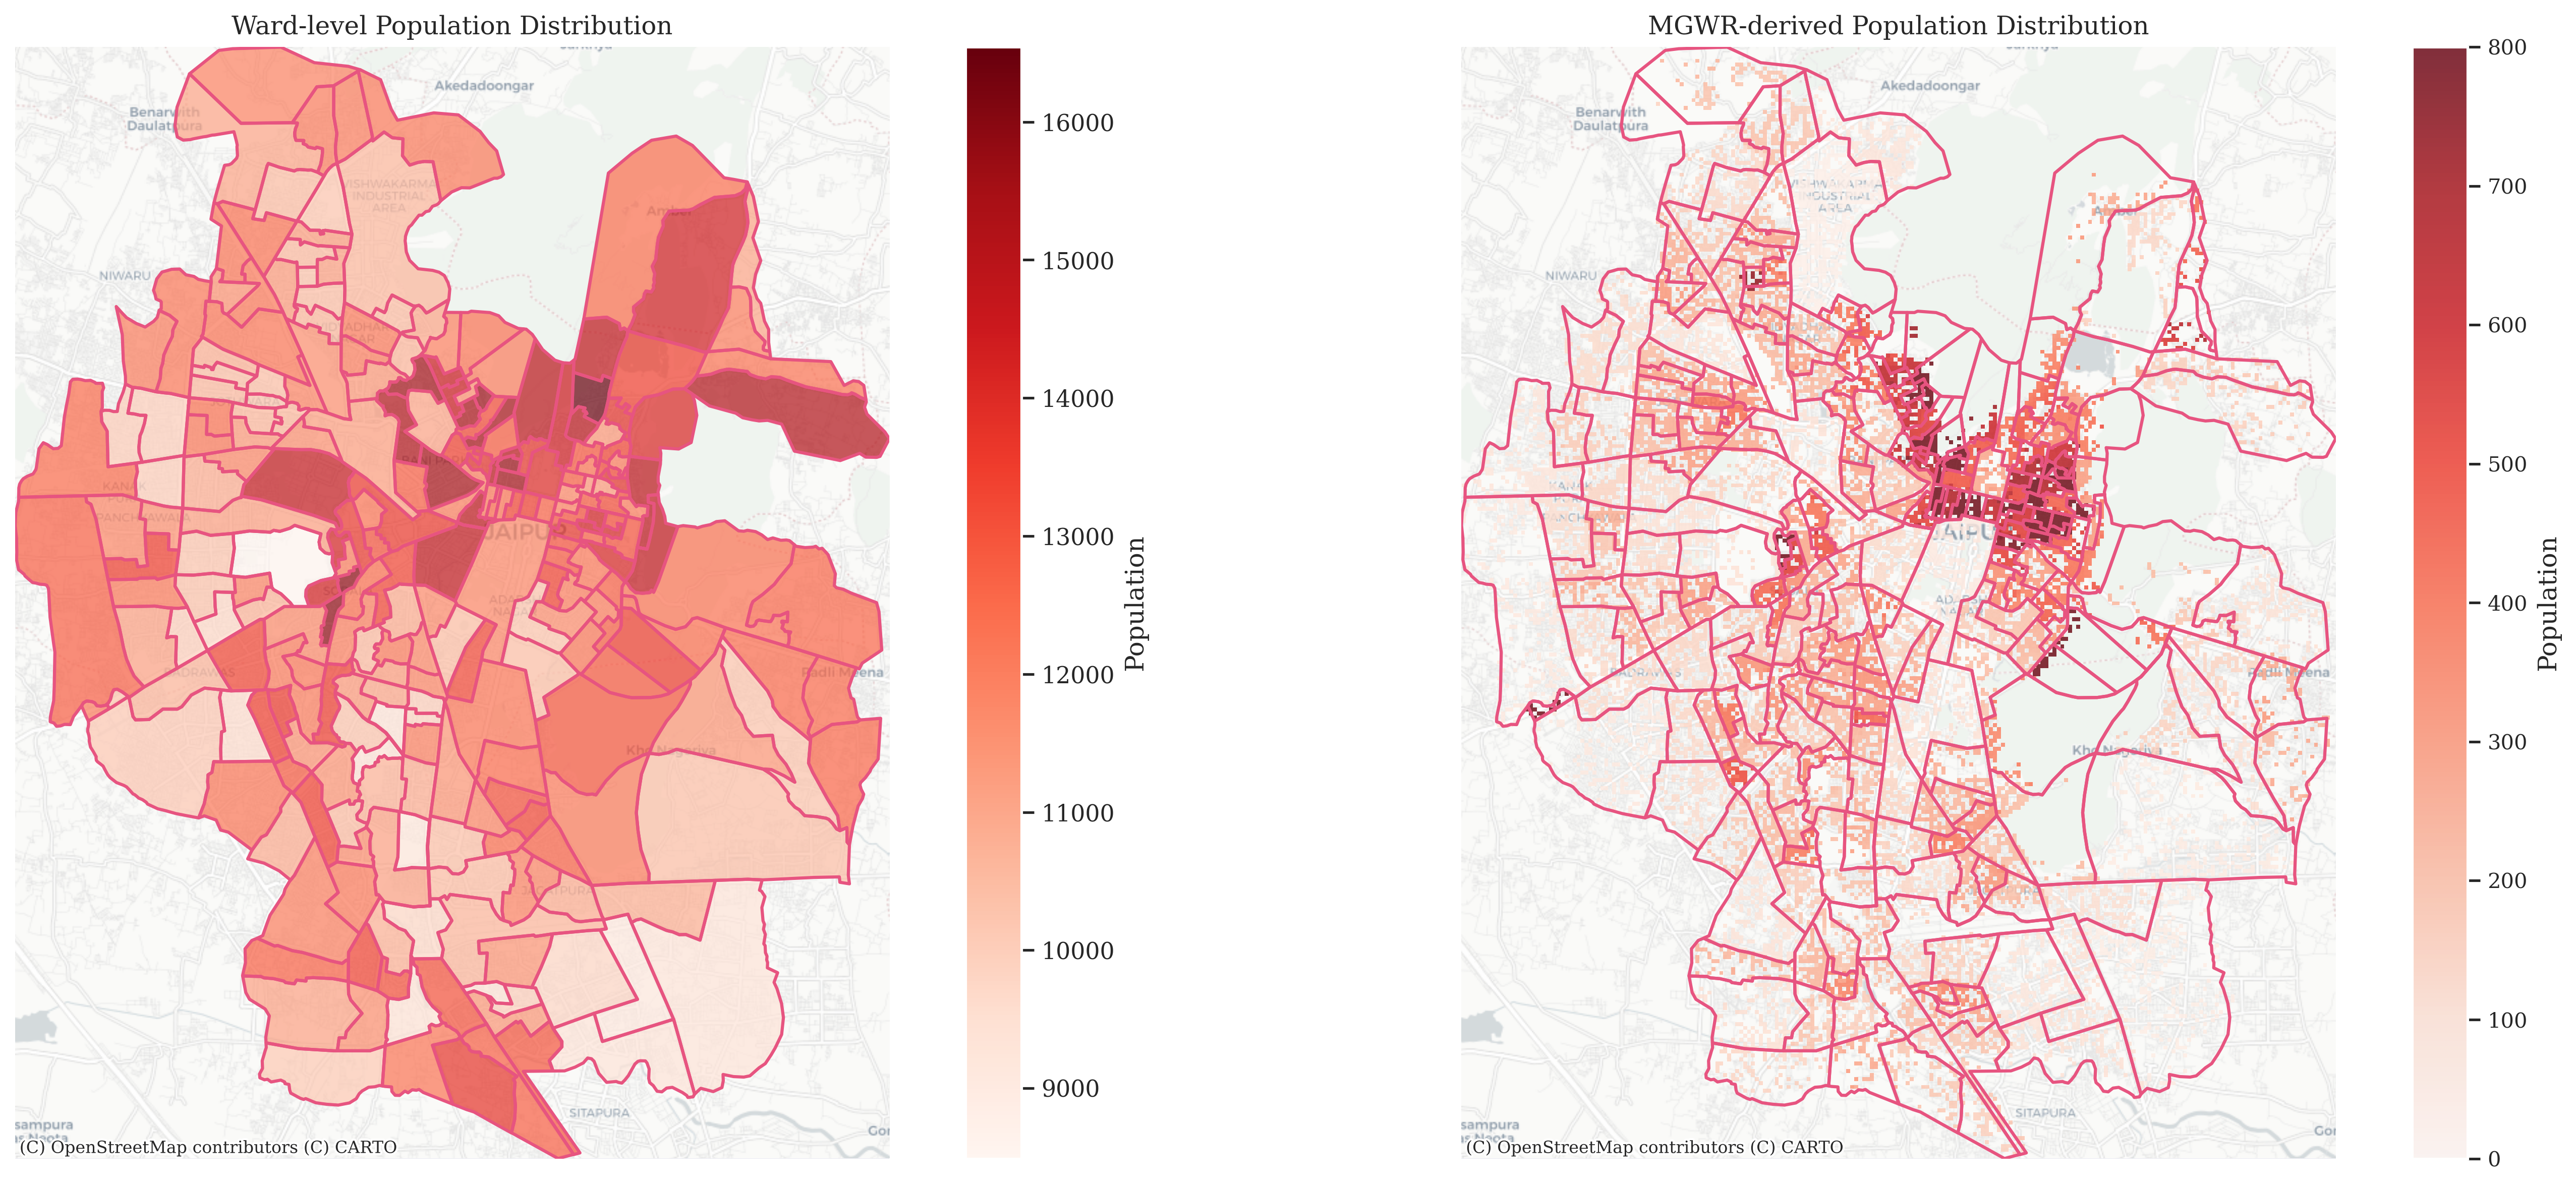

In [22]:


# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Load the GeoJSON file
ward_gdf = gpd.read_file('data/raw/JMC_all_v2.geojson')

# Ensure the GeoDataFrame has the correct CRS for contextily
if ward_gdf.crs != 'EPSG:3857':
    ward_gdf_web_mercator = ward_gdf.to_crs(epsg=3857)
else:
    ward_gdf_web_mercator = ward_gdf


ward_bounds = ward_gdf_web_mercator.total_bounds
unified_extent = [ward_bounds[0], ward_bounds[2], ward_bounds[1], ward_bounds[3]]

# Left subplot: Ward-level population distribution with basemap

ax1.set_xlim(unified_extent[0], unified_extent[1])
ax1.set_ylim(unified_extent[2], unified_extent[3])

# Add basemap first
cx.add_basemap(ax1,
               crs=ward_gdf_web_mercator.crs,
               source=cx.providers.CartoDB.Positron,
               alpha=1)

# Plot ward-level population data
ward_gdf_web_mercator.plot(column='POP',
                          cmap='Reds',
                          ax=ax1,
                          legend=True,
                          legend_kwds={'label': 'Population', 'orientation': 'vertical'},
                          alpha=0.7)

# Add boundary overlay with darkpink color (no fill)
ward_gdf_web_mercator.plot(ax=ax1,
                          facecolor='none',
                          edgecolor='#E75480',
                          linewidth=1.5)

ax1.set_title('Ward-level Population Distribution')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
# Remove axis spines for cleaner look
for spine in ax1.spines.values():
    spine.set_visible(False)

# Right subplot: Raster population data masked by ward boundaries
# Path to the raster file
raster_path = 'population_and_id_100m_mgwr04.tif'


ax2.set_xlim(unified_extent[0], unified_extent[1])
ax2.set_ylim(unified_extent[2], unified_extent[3])

# Add basemap first
cx.add_basemap(ax2,
               crs='EPSG:3857',
               source=cx.providers.CartoDB.Positron,
               alpha=1)

# Open the raster file
with rasterio.open(raster_path) as src:
    # Get raster CRS and convert ward boundaries to match
    raster_crs = src.crs
    if ward_gdf.crs != raster_crs:
        ward_gdf_raster_crs = ward_gdf.to_crs(raster_crs)
    else:
        ward_gdf_raster_crs = ward_gdf

    # Read the raster data and mask it by ward boundaries
    from rasterio.mask import mask
    import numpy as np

    # Create geometries for masking
    geometries = ward_gdf_raster_crs.geometry.values

    # Mask the raster WITHOUT cropping to maintain original extent
    masked_data, masked_transform = mask(src, geometries, crop=False, nodata=np.nan)

    # Get the first band (population data)
    band1_masked = masked_data[0]

    # Get original raster bounds
    bounds = src.bounds

    # Convert raster extent to Web Mercator for consistent plotting
    if raster_crs != 'EPSG:3857':
        import pyproj
        transformer = pyproj.Transformer.from_crs(raster_crs, 'EPSG:3857', always_xy=True)
        left, bottom = transformer.transform(bounds.left, bounds.bottom)
        right, top = transformer.transform(bounds.right, bounds.top)
        raster_extent_mercator = [left, right, bottom, top]
    else:
        raster_extent_mercator = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # Plot the masked raster
    im = ax2.imshow(band1_masked,
                    cmap='Reds',
                    interpolation='none',
                    vmin=0,
                    vmax=800,
                    extent=raster_extent_mercator,
                    alpha=0.8)

# Plot ward boundaries on right subplot 
                          facecolor='none',
                          edgecolor='#E75480',
                          linewidth=1.5)

# Add colorbar for raster
cbar = plt.colorbar(im, ax=ax2, label='Population')
cbar.ax.tick_params(labelsize=10)

ax2.set_title('MGWR-derived Population Distribution')
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])

# Remove axis spines for cleaner look
for spine in ax2.spines.values():
    spine.set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('image/analysis/population_comparison_maps.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

plt.show()
